# Introduction

This notebook performs simple scaling analysis on agglomerative attention layers. To isolate the effects of algorithmic complexity and avoid the complexities of dealing with load balancing and GPU memory limitations, this notebook runs on a single CPU core.

## `keras_transformer` Installation

This notebook requires a modified version of [`keras_transformer`](https://github.com/kpot/keras-transformer), which was developed by [Kirill Mavreshko](https://github.com/kpot). The modified version can be installed from source as follows:

```
git clone https://github.com/klarh/keras-transformer
pip install -e ./keras-transformer
```

In [1]:
import os
# don't allow tensorflow to find any GPUs that are present
os.environ['CUDA_VISIBLE_DEVICES'] = ''
import numpy as np
import keras
import keras.backend as K
import matplotlib, matplotlib.pyplot as pp
import sys
import tensorflow as tf
import timeit
import collections
import itertools
import tqdm
import gc

import keras_transformer, keras_transformer.attention

# don't allow tensorflow to use CPU parallelism
tf_config = tf.ConfigProto(
    intra_op_parallelism_threads=1,
    inter_op_parallelism_threads=1,
)
tf_config.gpu_options.allow_growth = True
tf_config.graph_options.optimizer_options.global_jit_level = tf.OptimizerOptions.OFF
session = tf.Session(config=tf_config)
K.set_session(session)

Using TensorFlow backend.


In [2]:
def make_model(seq_len, input_dim=512, attn_heads=4, 
               agglomerative=False, use_masking=True):
    inputs = keras.layers.Input(shape=(seq_len, input_dim))
    if agglomerative:
        attn = keras_transformer.attention.MultiHeadAgglomerativeSelfAttention(
            num_heads=attn_heads, use_masking=use_masking)(inputs)
    else:
        attn = keras_transformer.attention.MultiHeadSelfAttention(
            num_heads=attn_heads, use_masking=use_masking)(inputs)
        
    result = K.function([inputs], [attn])
    return inputs, result

In [3]:
timings = collections.defaultdict(list)
seq_lens = np.linspace(2048, 16, 16).astype(np.uint32)//16*16
seq_lens = list(reversed(np.unique(seq_lens)))
aggloms = [False, True]
masks = [False, True]
replicas = list(range(5))
call_number = 3

INPUT_DIM = 512
NUM_HEADS = 8
BATCH_SIZE = 32

def tqdm_auto(*args):
    total = np.product([len(v) for v in args])
    
    result = itertools.product(*args)
    result = tqdm.tqdm_notebook(result, total=total)
    return result

iterations = tqdm_auto(seq_lens, aggloms, masks, replicas)

for (seq_len, agglomerative, mask, _) in iterations:
    key = (seq_len, agglomerative, mask)
    (inp_var, m) = make_model(
        seq_len, INPUT_DIM, NUM_HEADS, agglomerative, mask)    
    inp = np.random.normal(size=(BATCH_SIZE, seq_len, INPUT_DIM))

    t = timeit.timeit('m([inp])', number=call_number, globals=globals())
    K.clear_session()
    gc.collect()
    timings[key].append(t/call_number)

Instructions for updating:
Colocations handled automatically by placer.



/usr/lib/python3.7/site-packages/matplotlib/figure.py:2369: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


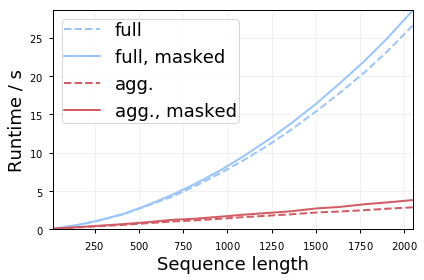

In [4]:
colors = pp.rcParams['axes.prop_cycle'].by_key()['color']

for (agglom, color) in zip(aggloms, colors):
    for mask in masks:
        xs, ys, sigs = [], [], []
        for seq_len in seq_lens:
            key = (seq_len, agglom, mask)
            mu, error = np.mean(timings[key]), np.std(timings[key])
            
            error /= np.sqrt(len(timings[key]))

            xs.append(seq_len)
            ys.append(mu)
            sigs.append(error)

        ys = np.array(ys)
        
        label = 'agg.' if agglom else 'full'
        if mask:
            label = label + ', masked'
            
        linestyle = '-' if mask else '--'
        # hide error bars for final version of figure since they are so small
#         pp.fill_between(xs, ys - sigs, ys + sigs, color='gray', alpha=.5)
        pp.plot(xs, ys, label=label, color=color, linestyle=linestyle)
    
pp.xlabel('Sequence length')
pp.ylabel('Runtime / s')
pp.legend()
pp.savefig('../media/sequence_length_runtime.pdf')